In [228]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import cv2
import seaborn as sns

In [229]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [230]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
experiment = "Lung"
core = "C6"
datasets = [
    core + "_1",
    core + "_2",
    core + "_3",
    core + "_4",
]

# Get images

In [243]:
from typing import List
from skimage import measure
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from functools import partial
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from skimage.filters import threshold_otsu

h5_data_dir = p_dir / "data" / "h5"

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img, n_min=1, n_max=100):
    # Contrast stretching
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    try:
        border = info['border']
        img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT, None, value = 0)
    except: pass
    img = rotate(img, rotation, resize=True)
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]

    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img, n_min=0, n_max=100)
    return img


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [244]:
imgs_imc_all = {}
skip_list = ["CD11b", 'CD11c']

for dataset in datasets:
    imgs_raw, markers_raw = get_imgs(f"{experiment} {core}", "IMC")
    imgs = []
    markers = []
    for i,img in enumerate(imgs_raw):
        if markers_raw[i] in skip_list:
            continue
        imgs.append(img)
        markers.append(markers_raw[i])
    imgs_imc_all[f"{experiment}_{dataset}"] = imgs

In [245]:
for dataset in datasets:
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    
    imgs_imc = imgs_imc_all["_".join([experiment, dataset])]


In [254]:
import napari 

napari.view_image(np.stack(imgs_imc)[:, 200:-300, 200:-300], channel_axis=0, name=markers, visible=False)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 499.5, 499.5), zoom=0.56905, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 1000.0, 1.0), (0.0, 1000.0, 1.0)), current_step=(500, 500), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'SMA' at 0x12de854e1c0>, <Image layer 'Vimentin' at 0x12de8f51790>, <Image layer 'PanKeratin' at 0x12de8fc2ee0>, <Image layer 'CD31' at 0x12de9da8460>, <Image layer 'CD44' at 0x12de9e3e9a0>, <Image layer 'FoxP3' at 0x12de9ed2ee0>, <Image layer 'CD4' at 0x12dea641460>, <Image layer 'ECadherin' at 0x12dea6d69a0>, <Image layer 'CD68' at 0x12dea76bee0>, <Image layer 'CD20' at 0x12dea806460>, <Image layer 'CD8' at 0x12dea89a9a0>, <Image layer 'CD45RA' at 0x12dea92

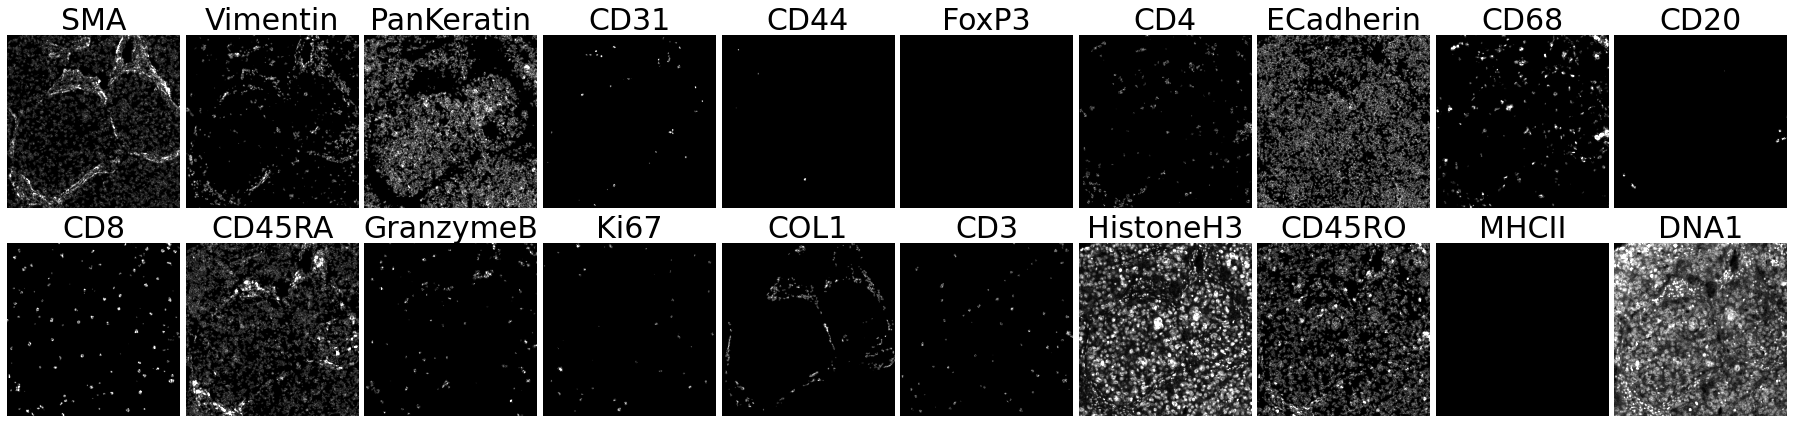

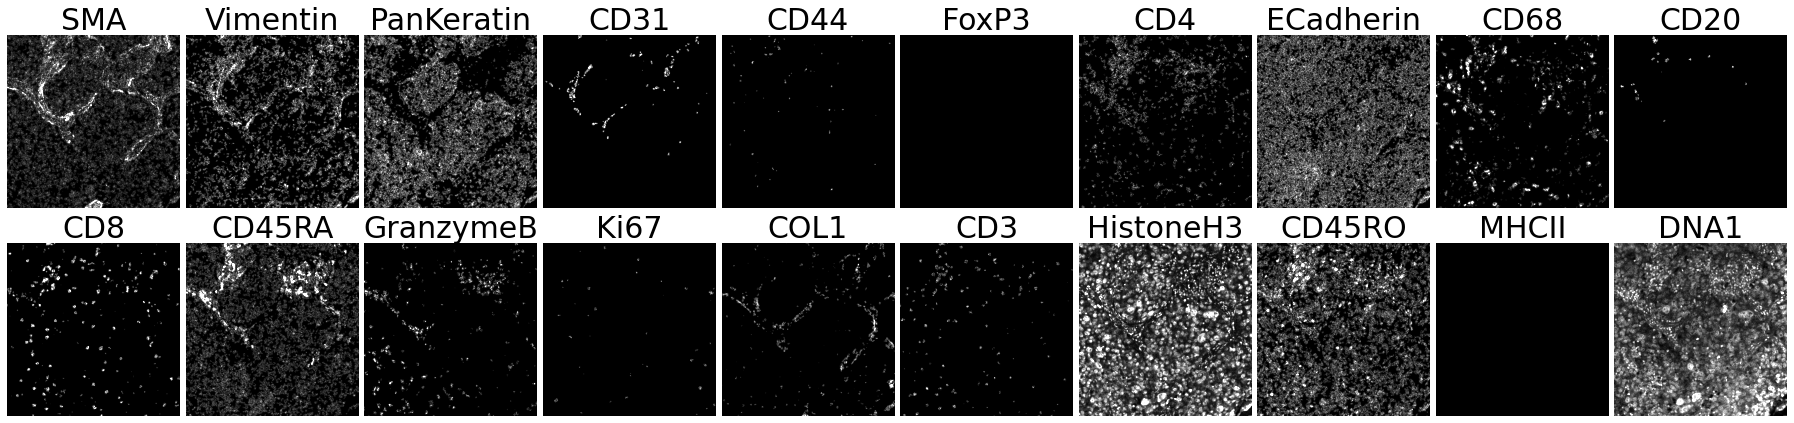

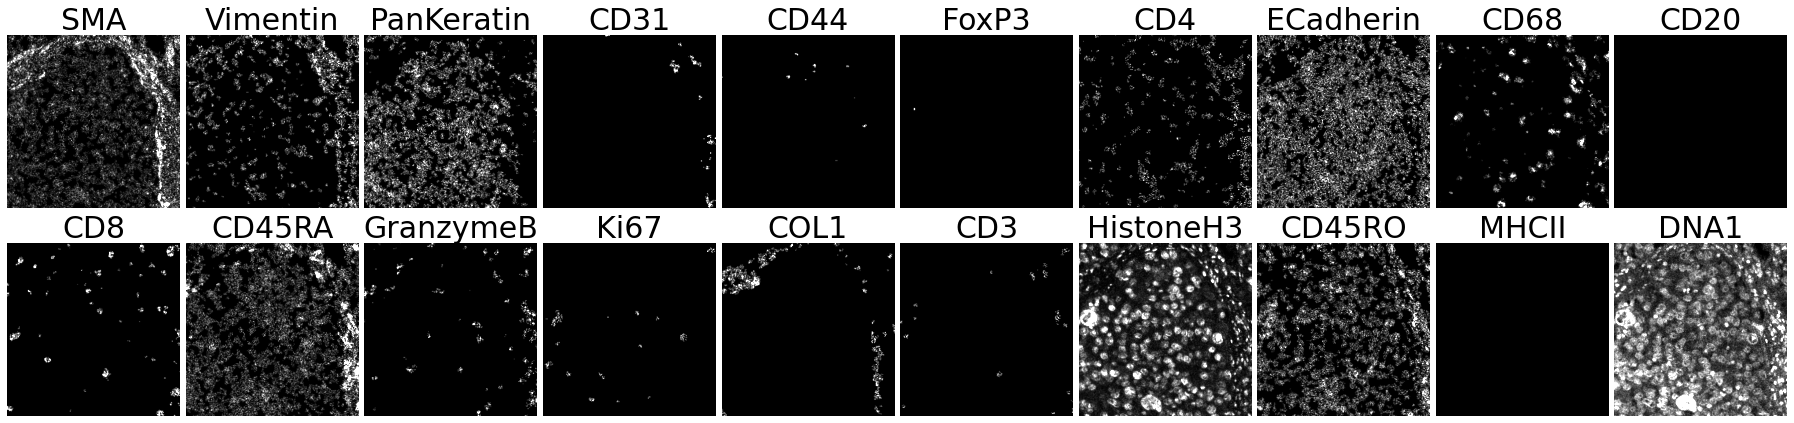

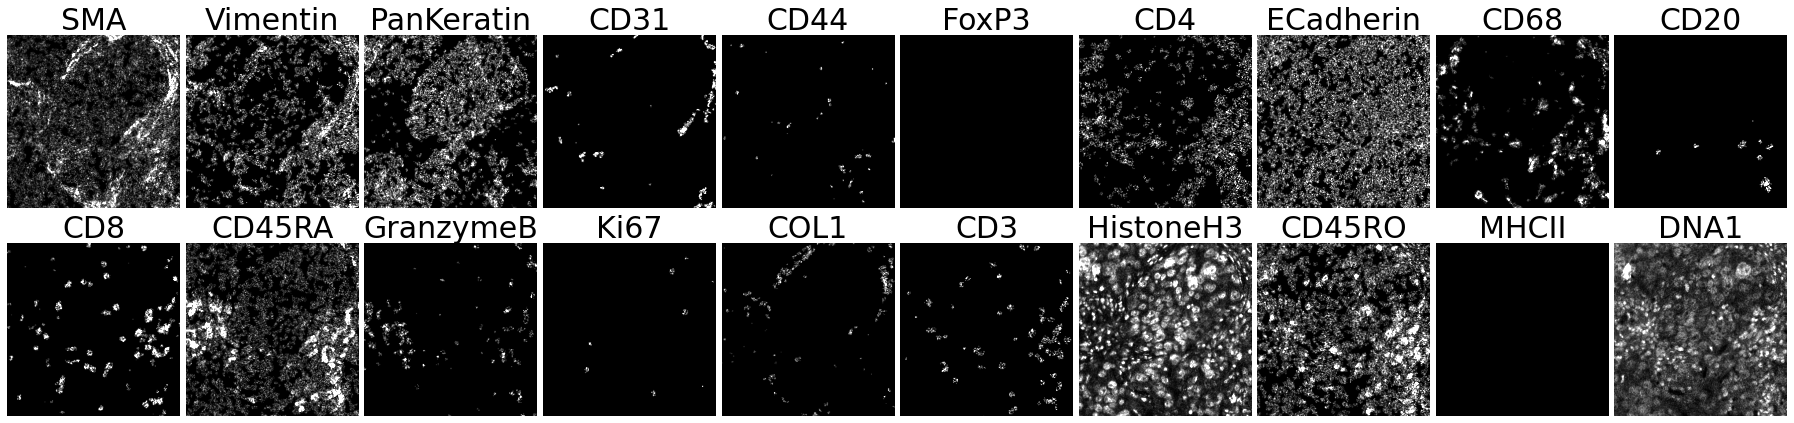

In [236]:
for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue

    # ---- Load IMC image
    imgs =  [crop_img(contrast_stretching(img), info) for img in imgs_imc]
    
    filename = p_dir / 'figures' / 'IMC' / f'{dataset}.png'
    fig, ax = plt.subplots(2, 10, figsize=(32,7))
    ax = ax.flatten()
    for i, ax in enumerate(ax):
        try:
            ax.imshow(imgs[i], cmap='gray', interpolation=None, vmax=100)
            ax.set_title(f'{markers[i]}', fontsize=30)
        except:
                
            pass
        ax.axis('off')
    fig.subplots_adjust(wspace=0.001)
    fig.savefig(filename,bbox_inches='tight',transparent=True, pad_inches=0)
